In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def Find_ESS(lambda0):
    # find the ES=E[z] and ESS=E[zz^T]
    N, K = lambda0.shape
    ES = lambda0 
    ESS = lambda0.T @ lambda0 
    ESS = ESS - np.diag(np.diag(ESS)) + np.diag(np.sum(ES, axis=0))

    return ES, ESS


def Find_lambda(X, mu, sigma, pie, lambda0, beta):
    N_, K = lambda0.shape
    lambda_new = lambda0
    diag_mu = np.diag(mu.T@mu + np.diag(beta)).flatten()
    for k in range(K):
        x = (np.log(pie[:, k]/(1-pie[:, k]))
                 + 1 / (sigma**2)
                 * ((X-lambda_new@mu.T)@mu[:, k]
                +lambda_new[:, k]*diag_mu[k]
                - 0.5*diag_mu[k]
                 )
                 )
        # contorl the overflow
        x[x > 100] = 100
        x[x < -100] = -100
        lambda_new[:, k] = 1/(1+np.exp(-x))
    return lambda_new

def Find_Free_Energy(X, mu, sigma, pie, lambda0, alpha, beta):
    # Compute the free energy
    N, D = X.shape # Number of samples and dimensionality
    _, K = lambda0.shape # Number of clusters

    # Regularize lambda0 to avoid numerical issues
    lambda0[lambda0 >= 1] = 1 - 1e-12
    lambda0[lambda0 <= 0] = 1e-12

    # Compute ES and ESS
    ES, ESS = Find_ESS(lambda0)

    # Compute the diagonal of mu
    diagmu = np.diag(mu.T @ mu).flatten()

    # Free energy calculation
    F = - 0.5 * N * D * np.log(2 * np.pi * sigma**2)  # Constant term
    F -= 0.5 / sigma**2 * (
        np.trace(X.T @ X) +
        np.trace(mu.T @ mu @ ESS) -
        2 * np.trace(ES.T @ X @ mu)
    )  # Quadratic term
    F += np.sum(lambda0 * np.log(pie/lambda0) + (1 - lambda0) * np.log((1 - pie)/(1 - lambda0)))
      # Prior and entropy term

    F -=   0.5 * D * N * np.sum(np.log(2 * np.pi * (1/alpha))) + N * np.sum( alpha/2 * np.diag(diagmu) )

    F +=  0.5 * D * N * np.sum(np.log(2 * np.pi * beta)) + 0.5 * N * K * D

    return F

def Find_Mu(X, lambda0, sigma, alpha):
    N, D = X.shape
    _, K = lambda0.shape
    mu = np.zeros((D, K))
    lambda_new = lambda0
    for k in range(K):
        mu[:, k] = (np.sum(X.T*lambda_new[:, k], axis=1) - np.sum((lambda_new@mu.T).T*lambda_new[:,k], axis=1)
                            + (mu[:, k] * np.sum(lambda_new[:, k]**2))
                    /(np.sum(lambda_new[:, k]) + N * sigma**2 * alpha[k])
        )

    mu[mu > 1e100] = 1e100
    mu[mu < 1e-100] = 1e-100
    return mu
def Find_Beta(sigma, lambda0, alpha, beta):
    _, K = lambda0.shape
    for k in range(K):
        beta[k] = (np.sum(lambda0[:, k]/(sigma**2) + alpha[k])) ** (-1)
    return beta

def MeanField(X, mu, sigma, pie, lambda0, alpha, beta, maxsteps):
    # track the free energy
    Fs = []
    lambda_old = lambda0
    # early stopping
    eplison = 1e-10
    for i in range(maxsteps):
        lambda_new = Find_lambda(X, mu, sigma, pie, lambda_old, beta)
        mu = Find_Mu(X, lambda_new, sigma, alpha)
        beta = Find_Beta(sigma, lambda_new, alpha, beta)
        F = Find_Free_Energy(X, mu, sigma, pie, lambda_new, alpha, beta)
        Fs.append(F)
        if i > 10 and np.abs(Fs[-1] - Fs[-2]) < eplison:
            break
        lambda_old = lambda_new
    return lambda_old, Fs, mu, beta


In [4]:
def m_step(X, ES, ESS, mu, beta):
    """
    mu, sigma, pie = MStep(X,ES,ESS)

    Inputs:
    -----------------
           X: shape (N, D) data matrix
          ES: shape (N, K) E_q[s]
         ESS: shape (K, K) sum over data points of E_q[ss'] (N, K, K)
                           if E_q[ss'] is provided, the sum over N is done for you.

    Outputs:
    --------
          mu: shape (D, K) matrix of means in p(y|{s_i},mu,sigma)
       sigma: shape (,)    standard deviation in same
         pie: shape (1, K) vector of parameters specifying generative distribution for s
    """
    N, D = X.shape
    if ES.shape[0] != N:
        raise TypeError('ES must have the same number of rows as X')
    K = ES.shape[1]
    if ESS.shape == (N, K, K):
        ESS = np.sum(ESS, axis=0)
    if ESS.shape != (K, K):
        raise TypeError('ESS must be square and have the same number of columns as ES')

    sigma = np.sqrt((np.trace(np.dot(X.T, X)) + np.trace(np.dot(np.dot(mu.T, mu), ESS))
                     - 2 * np.trace(np.dot(np.dot(ES.T, X), mu))) / (N * D))
    pie = np.mean(ES, axis=0, keepdims=True)

    alpha = D / np.diag(np.dot(mu.T, mu) + np.diag(beta)) 
    
    return alpha, sigma, pie

In [9]:
def LearnBinFactors(X, K, iterations):
    # LearnBinFactors learns the parameters of a binary factor analysis model
    N, D = X.shape
    
    # Initialize parameters
    lambda_ = np.random.rand(N, K)  # Shape (N, K)
    mu = np.random.rand(D, K)  # Shape (D, K)
    beta = np.ones(K)
    alpha = np.ones(K)*2
    sigma = 1
    pie = np.random.rand(1, K)  # Shape (1, K)


    # Keep track of free energy
    F_list = []

    for it in range(iterations):
        print(f"Iteration {it+1}:")

        # E-step: Update lambda using MeanField
        lambda_, Fs, mu, beta = MeanField(X, mu, sigma, pie, lambda_, alpha, beta, maxsteps=300)
        
        # M-step: Update parameters
        ES, ESS = Find_ESS(lambda_)
        alpha, sigma, pie = m_step(X, ES, ESS, mu, beta)

        # Keep track of free energy
        F = Find_Free_Energy(X, mu, sigma, pie, lambda_, alpha, beta)
        F_list.append(F)
        print(f"Free Energy = {F}")

        # stopping criterion
        if it > 100:
            if F_list[-1]-F_list[-2] < 1e-100:
                print("Reached cut-off after {} iterations".format(it))
                break
            # check for increase in F
            assert F_list[-1] >= F_list[-2]

    # Plot free energy
    plt.plot(F_list)
    plt.xlabel("Iteration")
    plt.ylabel("Free Energy")
    plt.grid()
    plt.title("Free Energy vs. Iteration")
    plt.savefig("free_energy.png")
    plt.show()
    

    return mu, sigma, pie, lambda_, alpha, F_list


In [6]:
def generate_feature_data(N=400, D=16, seed=0):



    np.random.seed(seed)

  # Define the basic shapes of the features

    m1 = [0, 0, 1, 0,
      0, 1, 1, 1,
      0, 0, 1, 0,
      0, 0, 0, 0]

    m2 = [0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0]

    m3 = [1, 1, 1, 1,
      0, 0, 0, 0,
      0, 0, 0, 0,
      0, 0, 0, 0]

    m4 = [1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1] 

    m5 = [0, 0, 0, 0,
      0, 0, 0, 0,
      1, 1, 0, 0,
      1, 1, 0, 0] 

    m6 = [1, 1, 1, 1,
      1, 0, 0, 1,
      1, 0, 0, 1,
      1, 1, 1, 1] 

    m7 = [0, 0, 0, 0,
      0, 1, 1, 0,
      0, 1, 1, 0,
      0, 0, 0, 0]

    m8 = [0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1]

    nfeat = 8 # number of features
    rr = 0.5 + np.random.rand(nfeat, 1) * 0.5 # weight of each feature between 0.5 and 1
    mut = np.array([rr[0] * m1, rr[1] * m2, rr[2] * m3, rr[3] * m4, rr[4] * m5,
                rr[5] * m6, rr[6] * m7, rr[7] * m8])
    s = np.random.rand(N, nfeat) < 0.3 # each feature occurs with prob 0.3 independently 

    # Generate Data - The Data is stored in Y

    Y = np.dot(s, mut) + np.random.randn(N, D) * 0.1 # some Gaussian noise is added 

    nrows = 13
    for k in range(16):
        plt.subplot(4, 4, k + 1)
        plt.imshow(np.reshape(Y[k], (4, 4)), cmap=plt.gray(), interpolation='none')
        plt.axis('off')

    plt.show()

    return Y

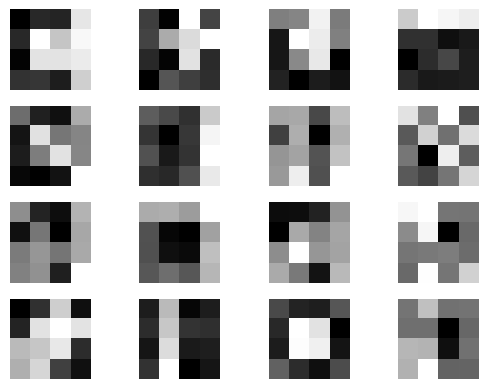

Iteration 1:
Free Energy = -117796.24539763156
Iteration 2:
Free Energy = -51209.31389264422
Iteration 3:
Free Energy = -51183.44015136728
Iteration 4:
Free Energy = -51157.64069074753
Iteration 5:
Free Energy = -51131.79001335846
Iteration 6:
Free Energy = -51105.887944974704
Iteration 7:
Free Energy = -51079.93431296991
Iteration 8:
Free Energy = -51053.92894385569
Iteration 9:
Free Energy = -51027.871663275175
Iteration 10:
Free Energy = -51001.7622959984
Iteration 11:
Free Energy = -50975.600665914826
Iteration 12:
Free Energy = -50949.38659602846
Iteration 13:
Free Energy = -50923.11990845343
Iteration 14:
Free Energy = -50896.80042440537
Iteration 15:
Free Energy = -50870.42796419468
Iteration 16:
Free Energy = -50844.00234722579
Iteration 17:
Free Energy = -50817.5233920482
Iteration 18:
Free Energy = -50790.991746412124
Iteration 19:
Free Energy = -50775.02696839161
Iteration 20:
Free Energy = -72284.46469524084
Iteration 21:
Free Energy = -117061.22698966227
Iteration 22:
Free

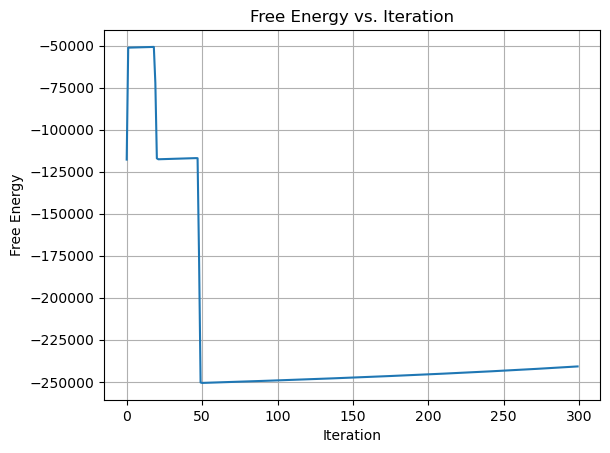

In [11]:
D = 16
N = 800
seed = 0
Y = generate_feature_data(N,D, seed)
K = 4
iterations = 300
mu, sigma, pie, lambda_, alpha, F_list = LearnBinFactors(Y, K, iterations)


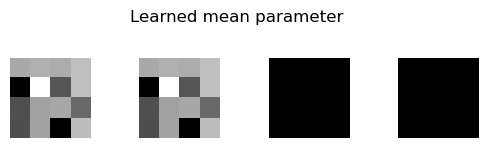

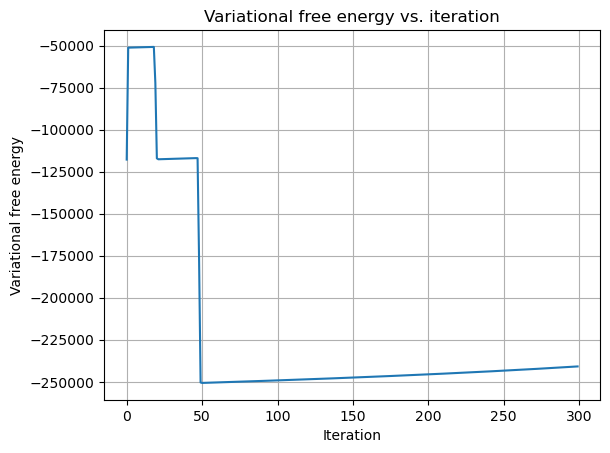

In [16]:
plt.figure()
for k in range(K):
    plt.subplot(4, 4, k + 1)
    plt.imshow(np.reshape(mu[:, k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')
plt.suptitle("Learned mean parameter")
plt.savefig("Q4_4_mean_parameter.png")
plt.show()


plt.figure()
plt.plot(F_list)
plt.grid()
plt.ylabel("Variational free energy")
plt.xlabel("Iteration")
plt.title("Variational free energy vs. iteration")
plt.savefig("Q4_4_free_energy.png")
plt.show()